# Import

## Modules

In [1]:
%load_ext autoreload
%autoreload 2

#Science and Data
import pandas as pd
import numpy as np
# from pandas_profiling import ProfileReport
from sklearn.model_selection import StratifiedShuffleSplit, TimeSeriesSplit, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score
from scipy.stats import randint

# Infrastructure
from pathlib import Path
import sys
import os

#Plotting Tools
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Pandas
pd.set_option('display.max_rows', 100)

# Matplotlib
%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.bottom'] = False
plt.rcParams['xtick.bottom'] = False
plt.rcParams['xtick.labelbottom'] = True
plt.rcParams['ytick.labelleft'] = True
plt.rcParams.update({'font.size': 18})

In [3]:
PROJECT_ROOT = !git rev-parse --show-toplevel
PROJECT_ROOT = Path(PROJECT_ROOT[0])
PATH_NOTEBOOK = PROJECT_ROOT / "notebooks"
PATH_TIME_SERIES = PATH_NOTEBOOK / "classification.time_series.xgboost"

## Data

src: https://archive.ics.uci.edu/ml/datasets/Occupancy+Detection

In [4]:
raw_data = pd.read_csv(PATH_TIME_SERIES / "data" / "raw" / "data1.csv")
raw_data = pd.concat([raw_data, pd.read_csv(PATH_TIME_SERIES / "data" / "raw" / "data2.csv"), pd.read_csv(PATH_TIME_SERIES / "data" / "raw" / "data3.csv")])

# Custom Function

In [5]:
class PanelTimeSeriesSplit(TimeSeriesSplit):
    
    def __init__(self):
        super().__init__()
        
    def split(self, X, y=None, groups=None, freq_train=None, freq_val=None, datetime_col=None):
        """Generate indices to split data into training and test set.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Training data, where n_samples is the number of samples
            and n_features is the number of features.
        y : array-like of shape (n_samples,)
            Always ignored, exists for compatibility.
        groups : array-like of shape (n_samples,)
            Always ignored, exists for compatibility.
        Yields
        ------
        train : ndarray
            The training set indices for that split.
        test : ndarray
            The testing set indices for that split.
        """
        X, y, groups = indexable(X, y, groups)
        n_samples = _num_samples(X)
        n_splits = self.n_splits
        n_folds = n_splits + 1
        if n_folds > n_samples:
            raise ValueError(
                ("Cannot have number of folds ={0} greater"
                 " than the number of samples: {1}.").format(n_folds,
                                                             n_samples))
        indices = np.arange(n_samples)
        test_size = (n_samples // n_folds)
        test_starts = range(test_size + n_samples % n_folds,
                            n_samples, test_size)
        for test_start in test_starts:
            if self.max_train_size and self.max_train_size < test_start:
                yield (indices[test_start - self.max_train_size:test_start],
                       indices[test_start:test_start + test_size])
            else:
                yield (indices[:test_start],
                       indices[test_start:test_start + test_size])

# Audit

## Data Types

In [6]:
raw_data.dtypes

date              object
Temperature      float64
Humidity         float64
Light            float64
CO2              float64
HumidityRatio    float64
Occupancy          int64
dtype: object

## Data Shape

In [7]:
raw_data.shape

(20560, 7)

## Duplicated Records

In [8]:
print(f"Number of duplicated records: {raw_data.duplicated().shape[0]}")

Number of duplicated records: 20560


# Data Cleaning and Feature Engineering

In [9]:
raw_data["date"] = pd.to_datetime(raw_data["date"])

# Exploratory Data Analysis

profile = ProfileReport(raw_data, title='Pandas Profiling Report', explorative=True)

profile.to_widgets()

# Time Series Plots

In [10]:
freq = "D"

In [11]:
plot_data = raw_data.set_index("date").resample(freq).mean().reset_index()

## Prior Probability

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Daily Plot of Prior Probability of Occupancy')

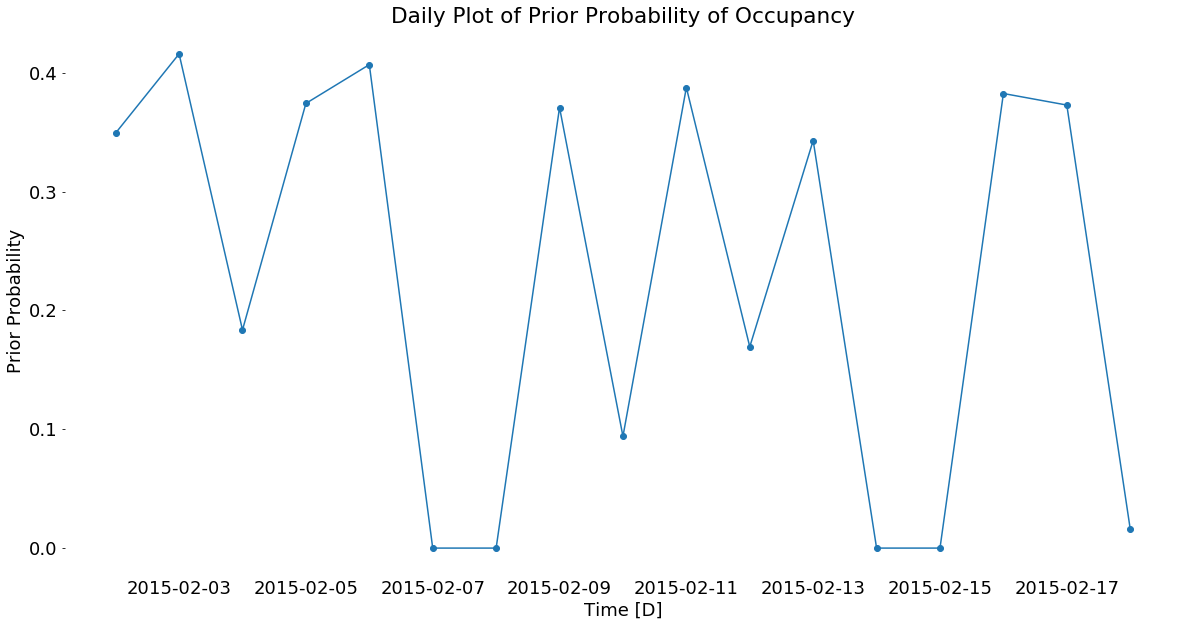

In [12]:
fig, ax = plt.subplots()
ax.plot(plot_data["date"], plot_data["Occupancy"], "o-")
ax.set_xlabel(f"Time [{freq}]")
ax.set_ylabel("Prior Probability")
ax.set_title("Daily Plot of Prior Probability of Occupancy")

## Temperature

Text(0.5, 1.0, 'Daily Plot of Average Temperature')

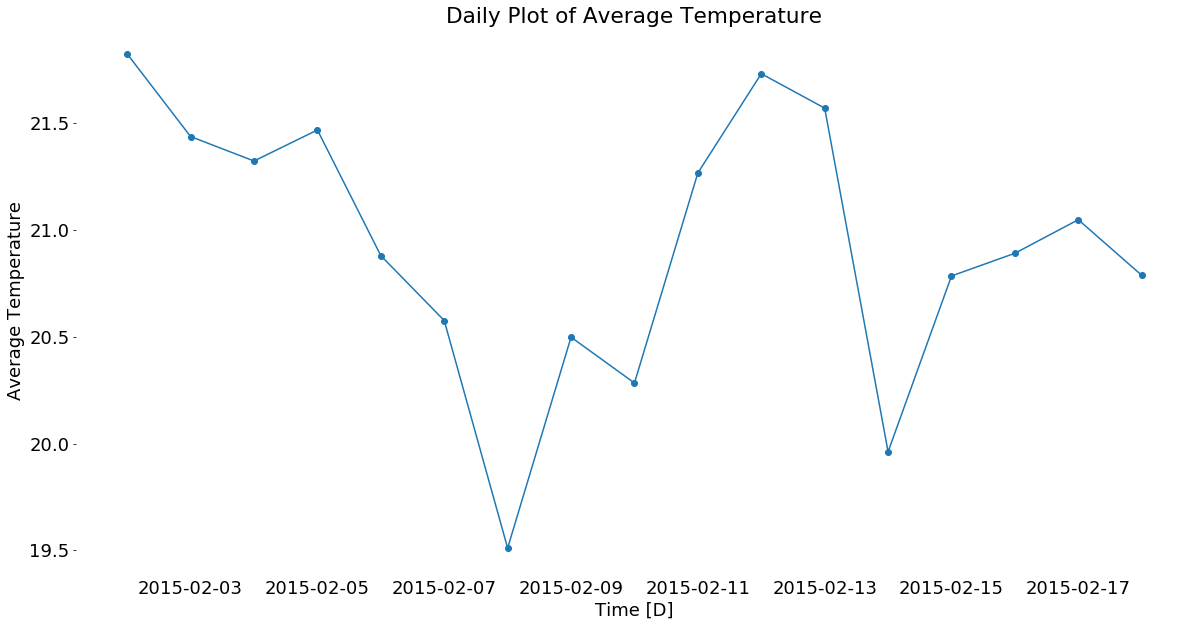

In [13]:
feature = "Temperature"
fig, ax = plt.subplots()
ax.plot(plot_data["date"], plot_data[feature], "o-")
ax.set_xlabel(f"Time [{freq}]")
ax.set_ylabel(f"Average {feature}")
ax.set_title(f"Daily Plot of Average {feature}")

## Light

Text(0.5, 1.0, 'Daily Plot of Average Light')

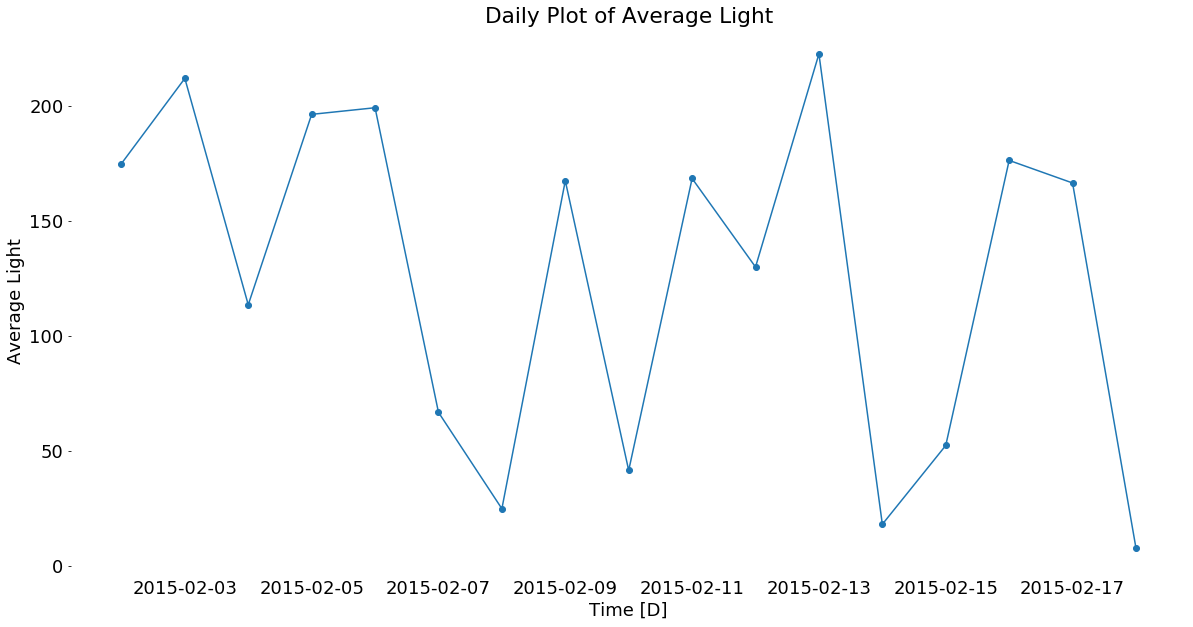

In [14]:
feature = "Light"
fig, ax = plt.subplots()
ax.plot(plot_data["date"], plot_data[feature], "o-")
ax.set_xlabel(f"Time [{freq}]")
ax.set_ylabel(f"Average {feature}")
ax.set_title(f"Daily Plot of Average {feature}")

## CO2

Text(0.5, 1.0, 'Daily Plot of Average CO2')

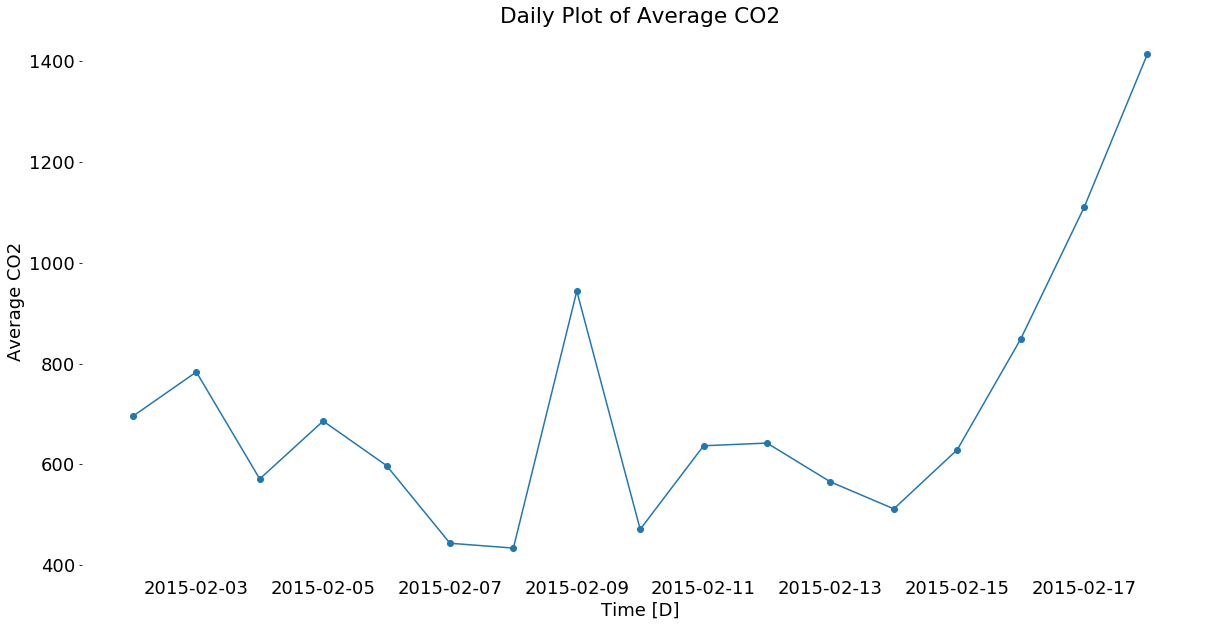

In [15]:
feature = "CO2"
fig, ax = plt.subplots()
ax.plot(plot_data["date"], plot_data[feature], "o-")
ax.set_xlabel(f"Time [{freq}]")
ax.set_ylabel(f"Average {feature}")
ax.set_title(f"Daily Plot of Average {feature}")

## Humidity Ratio

Text(0.5, 1.0, 'Daily Plot of Average HumidityRatio')

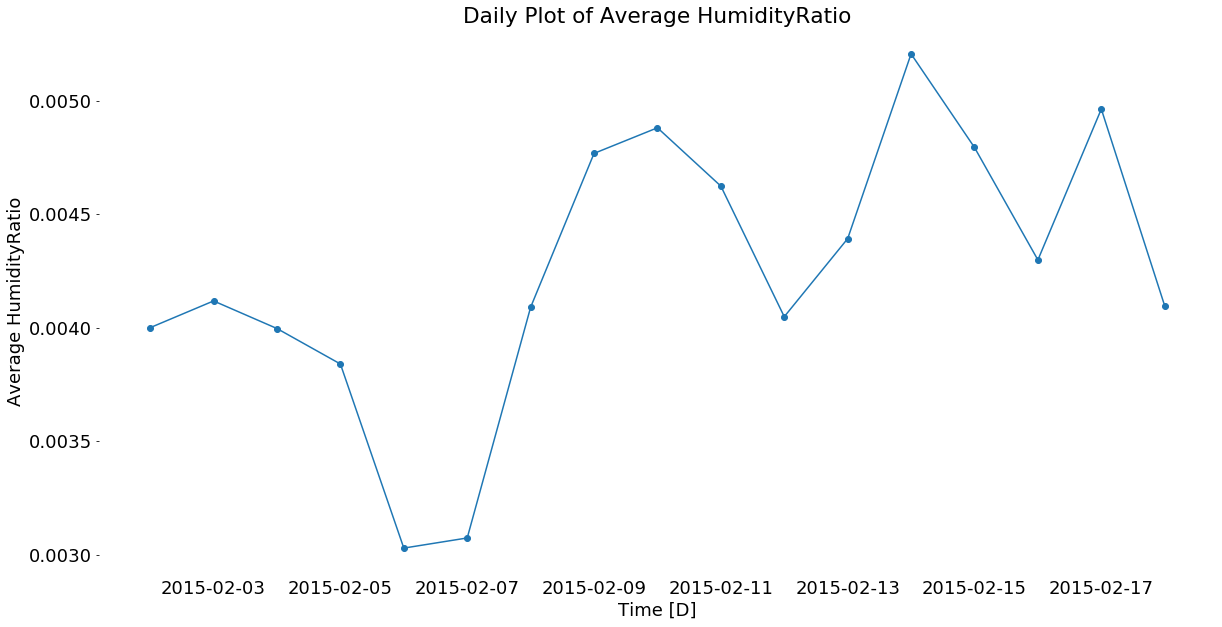

In [16]:
feature = "HumidityRatio"
fig, ax = plt.subplots()
ax.plot(plot_data["date"], plot_data[feature], "o-")
ax.set_xlabel(f"Time [{freq}]")
ax.set_ylabel(f"Average {feature}")
ax.set_title(f"Daily Plot of Average {feature}")

# Model

## Data Preparation

In [17]:
df = raw_data

In [18]:
y = df[["Occupancy"]]
X = df.drop(columns="Occupancy")

### Train Test Split

In [19]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=0)
for train_index, test_index in sss.split(X, y):
    X_is, X_os = X.iloc[train_index], X.iloc[test_index]
    y_is, y_os = y.iloc[train_index], y.iloc[test_index]

### Time Split

In [20]:
split_date = "2015-02-13"

In [21]:
mask_is = X_is["date"] <= split_date
mask_os = X_os["date"] <= split_date

X_tv, y_tv = X_is[mask_is], y_is[mask_is]
X_is_ot, y_is_ot = X_is[~mask_is], y_is[~mask_is]
X_os_it, y_os_it = X_os[mask_os], y_os[mask_os]
X_os_ot, y_os_ot = X_os[~mask_os], y_os[~mask_os]

datasets_dict = {"train_validation": {"X": X_tv, "y": y_tv}
                ,"in-sample-out-of-time": {"X": X_is_ot, "y": y_is_ot}
                ,"out-of-sample-in-time": {"X": X_os_it, "y": y_os_it}
                ,"out-of-sample-out-of-time": {"X": X_os_ot, "y": y_os_ot}
                }

del X_is_ot, y_is_ot, X_os_it, y_os_it, X_os_ot, y_os_ot

In [22]:
for dataset_type in datasets_dict.values():
    dataset_type["X"].reset_index(inplace=True, drop=True)
    dataset_type["y"].reset_index(inplace=True, drop=True)

## Prepare Estimator

In [23]:
estimator = RandomForestClassifier()

## Prepare Cross Validation

src: https://hub.packtpub.com/cross-validation-strategies-for-time-series-forecasting-tutorial/

In [24]:
X_tv.sort_values(by="date", inplace=True)

tscv = TimeSeriesSplit(n_splits=3)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [25]:
distributions = {"n_estimators": randint(10, 1000)}
clf = RandomizedSearchCV(estimator, distributions, cv=tscv)

In [26]:
search = clf.fit(X_tv.set_index("date"), y_tv)
search.best_params_

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:715: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


{'n_estimators': 675}

In [27]:
pd.DataFrame.from_dict(clf.cv_results_).sort_values(by="rank_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
2,3.617959,1.220752,0.133638,0.006870,675,{'n_estimators': 675},0.728984,0.730866,0.689460,0.716437,0.019090,1
8,5.144350,1.893470,0.212908,0.030800,991,{'n_estimators': 991},0.746550,0.690715,0.690088,0.709118,0.026470,2
7,1.213588,0.465127,0.045947,0.003978,237,{'n_estimators': 237},0.749686,0.658093,0.715809,0.707863,0.037813,3
5,5.200122,2.184571,0.220852,0.062080,982,{'n_estimators': 982},0.749059,0.675031,0.656838,0.693643,0.039883,4
6,1.474460,0.444122,0.054847,0.003973,283,{'n_estimators': 283},0.745295,0.654956,0.661230,0.687160,0.041187,5
9,3.274155,1.173181,0.127285,0.008667,656,{'n_estimators': 656},0.727102,0.676286,0.657465,0.686951,0.029412,6
4,1.737795,0.707588,0.065325,0.005956,330,{'n_estimators': 330},0.693852,0.720201,0.643664,0.685905,0.031747,7
3,2.044429,0.670779,0.086059,0.012713,391,{'n_estimators': 391},0.750941,0.647428,0.628607,0.675659,0.053784,8
0,0.837152,0.268943,0.032086,0.001505,161,{'n_estimators': 161},0.702635,0.636763,0.622334,0.653910,0.034953,9
1,0.135908,0.049402,0.006671,0.000711,28,{'n_estimators': 28},0.710163,0.597867,0.613551,0.640527,0.049655,10


In [28]:
estimator = clf.best_estimator_

# Test Model

In [56]:
performance_metrics = {"date": [], "dataset_type": [], "f1_score": [], "roc_auc_score": [], "recall_score": [], "precision_score": [], "support": []}

In [57]:
for test_type, datasets in datasets_dict.items():
    X = datasets["X"]
    y = datasets["y"]
    print(test_type)
    for day in X['date'].dt.day.unique():
        mask = X['date'].dt.day == day
        performance_metrics["date"].append(X.loc[mask, 'date'].dt.date.unique()[0])
        y_hat_proba = estimator.predict_proba(X[mask].set_index("date"))[:, 1]
        y_hat = estimator.predict(X[mask].set_index("date"))
        assert X[mask].shape[0] <= y.shape[0] 
        try:
            performance_metrics["roc_auc_score"].append(roc_auc_score(y.values.squeeze()[X[mask].index.values], y_hat_proba))

        except ValueError:
            performance_metrics["roc_auc_score"].append(np.nan)

        performance_metrics["f1_score"].append(f1_score(y.values.squeeze()[X[mask].index.values], y_hat))
        performance_metrics["recall_score"].append(recall_score(y.values.squeeze()[X[mask].index.values], y_hat))
        performance_metrics["precision_score"].append(precision_score(y.values.squeeze()[X[mask].index.values], y_hat))
        performance_metrics["dataset_type"].append(test_type)
        performance_metrics["support"].append(y.values.squeeze()[X[mask].index.values].shape[0])

train_validation


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predi

in-sample-out-of-time


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 du

out-of-sample-in-time


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


out-of-sample-out-of-time


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and bei

In [58]:
performance_metrics_df = pd.DataFrame.from_dict(performance_metrics)
performance_metrics_df.sort_values(by="date", inplace=True)

## Plots

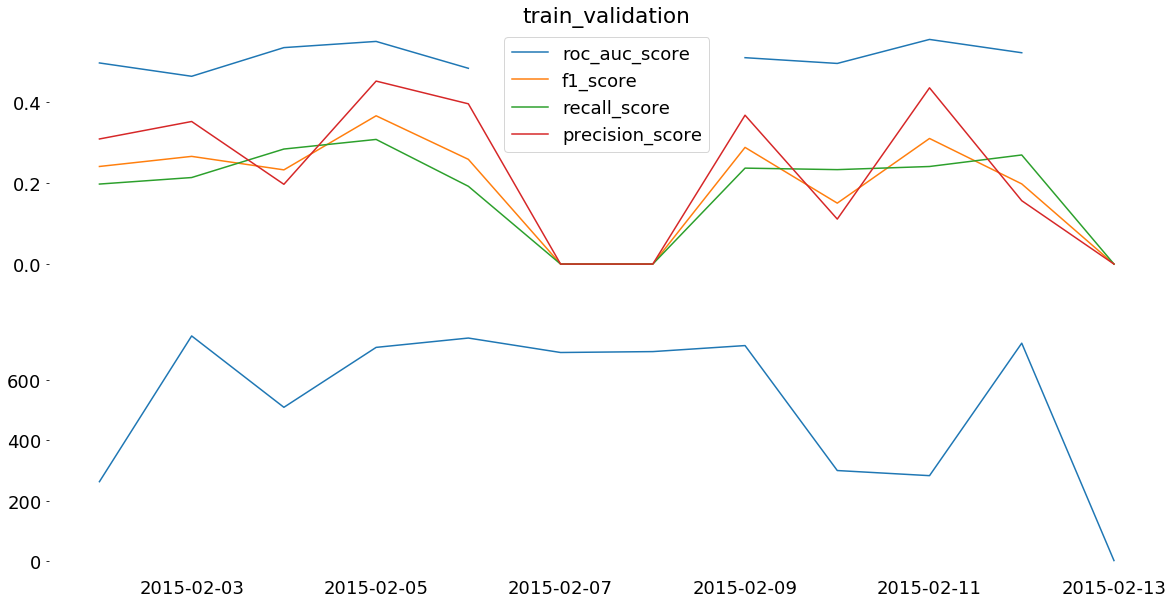

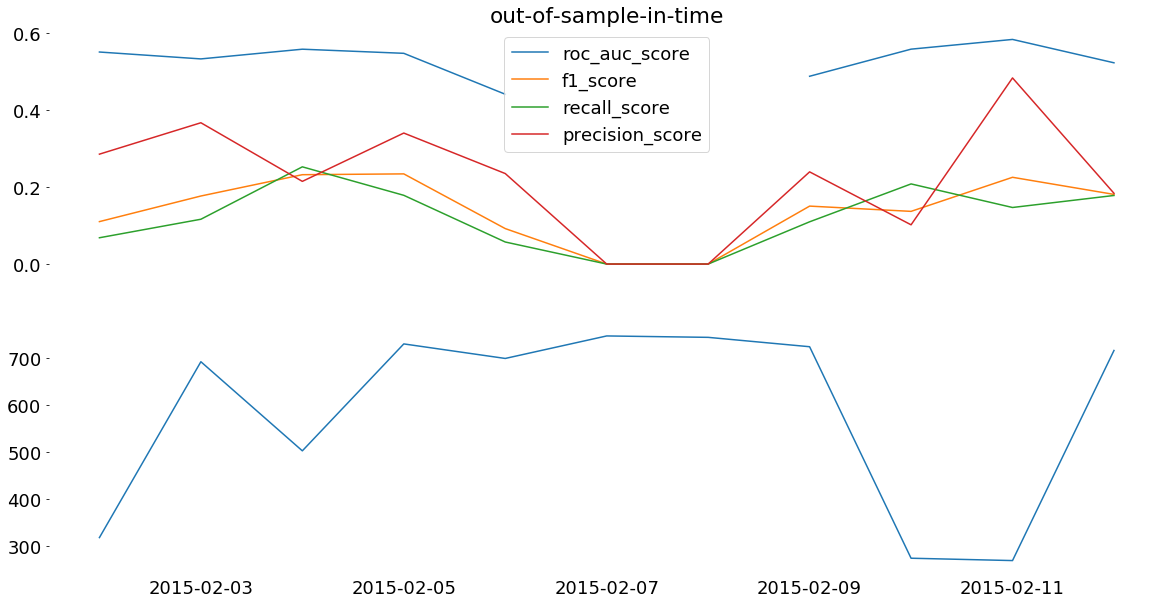

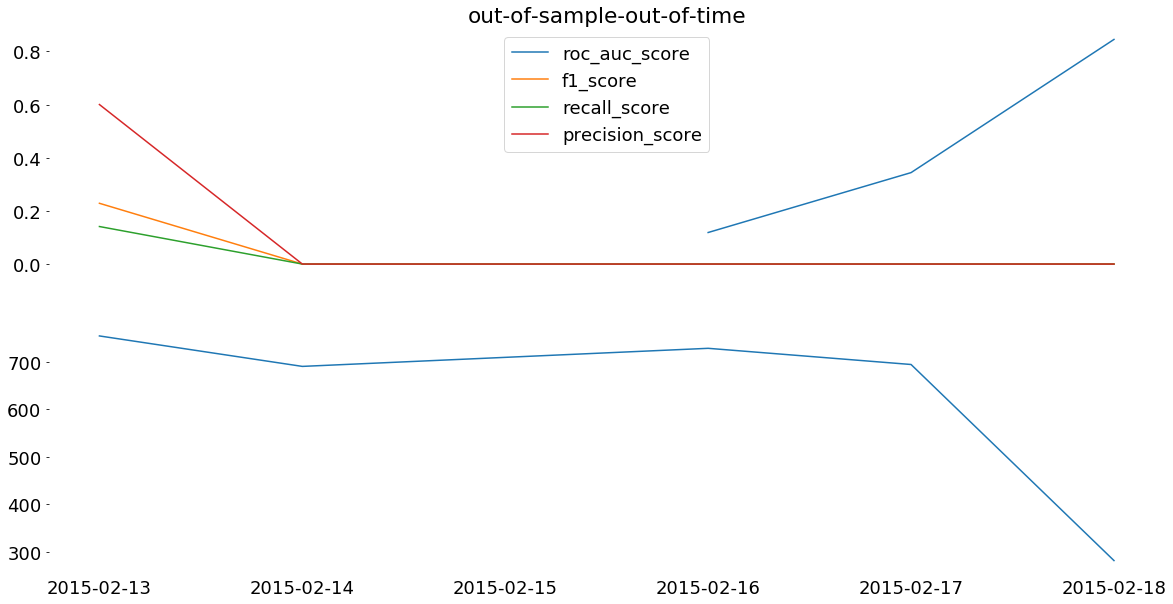

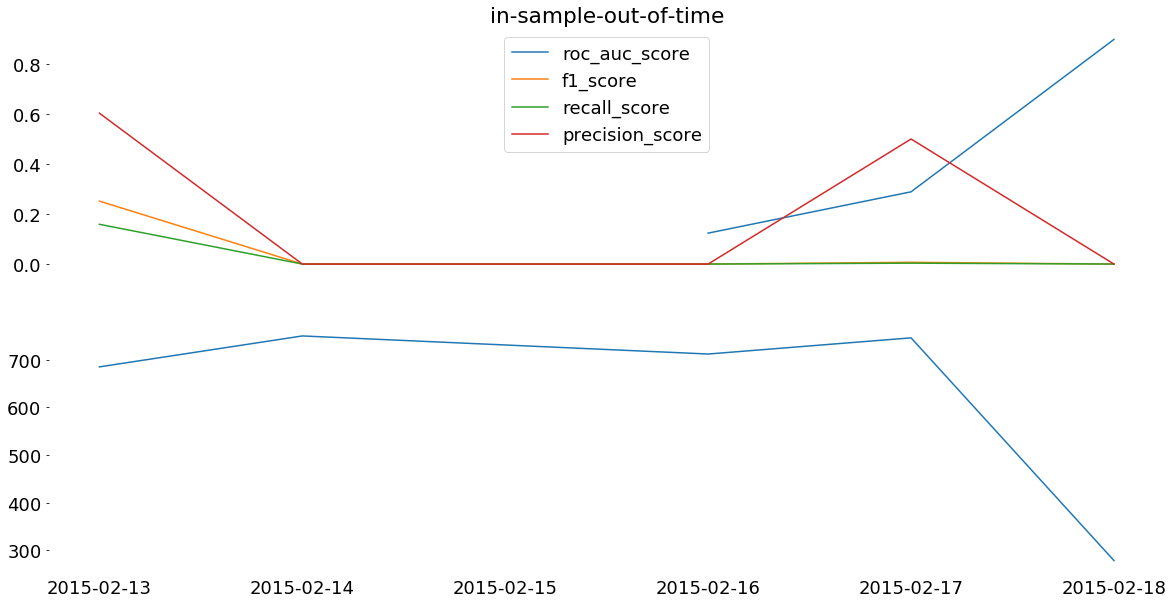

In [60]:
from itertools import product
for dataset_type in performance_metrics_df["dataset_type"].unique():
    fig, (pm, sup) = plt.subplots(nrows=2, sharex=True)
    for performance_metric in ["roc_auc_score", "f1_score", "recall_score", "precision_score"]:
        mask = performance_metrics_df["dataset_type"] == dataset_type
        pm.plot(performance_metrics_df.loc[mask, "date"], performance_metrics_df.loc[mask, performance_metric], label=performance_metric)
    sup.plot(performance_metrics_df.loc[mask, "date"], performance_metrics_df.loc[mask, "support"], label="support")
    
    pm.set_title(f"{dataset_type}")
    pm.legend()

# References

* https://machinelearningmastery.com/xgboost-for-time-series-forecasting/

* https://machinelearningmastery.com/backtest-machine-learning-models-time-series-forecasting/